# Phase 9: Ensemble Modeling — The "Super Model"

**Strategy:** Combine three algorithms with different strengths to create a robust ensemble.

| Model | Role | Strength |
|-------|------|----------|
| Logistic Regression | **Baseline** | Linear relationships (Elo diff → win prob) |
| Random Forest | **Complex** | Non-linear patterns, interactions |
| Gradient Boosting | **Corrector** | Learns from predecessor mistakes |
| **Soft-Vote Ensemble** | **Super Model** | Averages `predict_proba` across all 3 |

**Outputs:** `Ensemble_Projection.csv`, `Ensemble_vs_RF_Comparison.csv`, comparison chart.

In [1]:
# =============================================================================
# Cell 1: Setup & Data Load
# =============================================================================

import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Segoe UI', 'Arial', 'DejaVu Sans']

PROC = os.path.join('data', 'processed')
RES  = os.path.join('data', 'results')
ASSETS = 'Report_Assets'
os.makedirs(RES, exist_ok=True)
os.makedirs(ASSETS, exist_ok=True)

SIMULATIONS = 10_000
SEED = 42
np.random.seed(SEED)

# --- Load engineered data ---
df_train  = pd.read_csv(os.path.join(PROC, 'model_training_engineered.csv'))
df_future = pd.read_csv(os.path.join(PROC, 'future_predict_engineered.csv'))
df_banked = pd.read_csv(os.path.join(PROC, 'current_banked_engineered.csv'))

print(f'Training:  {len(df_train):,} rows')
print(f'Future:    {len(df_future):,} rows')
print(f'Banked:    {len(df_banked):,} rows')

# --- Feature set ---
FEATURES = [
    'elo_diff',
    'form_diff_l5',
    'home_finishing_efficiency_l5', 'away_finishing_efficiency_l5',
    'home_rest_days', 'away_rest_days',
    'attack_vs_defense_l5', 'defense_vs_attack_l5',
    'form_diff_l10',
]

# --- Encode target ---
label_map = {'A': 0, 'D': 1, 'H': 2}
label_names = ['Away Win', 'Draw', 'Home Win']

# Drop NaN in features + target
mask_train  = df_train[FEATURES + ['FTR']].notna().all(axis=1)
mask_future = df_future[FEATURES].notna().all(axis=1)

df_train_clean  = df_train[mask_train].copy()
df_future_clean = df_future[mask_future].copy()

X = df_train_clean[FEATURES]
y = df_train_clean['FTR'].map(label_map)

print(f'\nClean training rows: {len(X):,}  (dropped {len(df_train)-len(X)} with NaN)')
print(f'Clean future rows:   {len(df_future_clean):,}')
print(f'\nTarget distribution:')
for code, name in zip([0,1,2], label_names):
    pct = (y == code).mean() * 100
    print(f'  {name:10s}  {(y==code).sum():>5,}  ({pct:.1f}%)')
print(f'\nFeatures ({len(FEATURES)}):', FEATURES)

Training:  19,837 rows
Future:    648 rows
Banked:    1,104 rows

Clean training rows: 19,358  (dropped 479 with NaN)
Clean future rows:   632

Target distribution:
  Away Win    6,006  (31.0%)
  Draw        4,847  (25.0%)
  Home Win    8,505  (43.9%)

Features (9): ['elo_diff', 'form_diff_l5', 'home_finishing_efficiency_l5', 'away_finishing_efficiency_l5', 'home_rest_days', 'away_rest_days', 'attack_vs_defense_l5', 'defense_vs_attack_l5', 'form_diff_l10']


In [2]:
# =============================================================================
# Cell 2: Train the Three Constituent Models + Ensemble
# =============================================================================

# --- Temporal split: train on seasons before 23/24, validate on 23/24+ ---
# Season is integer-coded: 1415 = 2014-15, 2324 = 2023-24, etc.
split_season = 2324
train_mask = df_train_clean['season'] < split_season
val_mask   = ~train_mask

X_tr, X_val = X[train_mask], X[val_mask]
y_tr, y_val = y[train_mask], y[val_mask]

print(f'Train set: {len(X_tr):,} rows (seasons before {split_season})')
print(f'Val set:   {len(X_val):,} rows (season {split_season}+)')

# --- Scale features for Logistic Regression ---
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

# ===== MODEL 1: Logistic Regression (The "Baseline") =====
print('\n' + '='*55)
print('MODEL 1: Logistic Regression (Linear Baseline)')
print('='*55)
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, C=1.0)
lr.fit(X_tr_scaled, y_tr)
acc_lr = accuracy_score(y_val, lr.predict(X_val_scaled))
ll_lr  = log_loss(y_val, lr.predict_proba(X_val_scaled))
print(f'  Accuracy:  {acc_lr:.2%}')
print(f'  Log Loss:  {ll_lr:.4f}')

# ===== MODEL 2: Random Forest (The "Complex") =====
print('\n' + '='*55)
print('MODEL 2: Random Forest (Non-Linear Patterns)')
print('='*55)
rf = RandomForestClassifier(
    n_estimators=500, max_depth=8, min_samples_leaf=20,
    random_state=SEED, n_jobs=-1
)
rf.fit(X_tr, y_tr)
acc_rf = accuracy_score(y_val, rf.predict(X_val))
ll_rf  = log_loss(y_val, rf.predict_proba(X_val))
print(f'  Accuracy:  {acc_rf:.2%}')
print(f'  Log Loss:  {ll_rf:.4f}')

# ===== MODEL 3: Gradient Boosting (The "Corrector") =====
print('\n' + '='*55)
print('MODEL 3: Gradient Boosting (Bias Reducer)')
print('='*55)
gb = GradientBoostingClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=4,
    min_samples_leaf=20, subsample=0.8, random_state=SEED
)
gb.fit(X_tr, y_tr)
acc_gb = accuracy_score(y_val, gb.predict(X_val))
ll_gb  = log_loss(y_val, gb.predict_proba(X_val))
print(f'  Accuracy:  {acc_gb:.2%}')
print(f'  Log Loss:  {ll_gb:.4f}')

# ===== SUPER MODEL: Soft-Vote Ensemble =====
print('\n' + '='*55)
print('SUPER MODEL: Soft-Vote Ensemble')
print('='*55)

# Manual soft voting (averaging probabilities) so we can use
# the scaled data for LR but raw data for tree models
proba_lr  = lr.predict_proba(X_val_scaled)
proba_rf  = rf.predict_proba(X_val)
proba_gb  = gb.predict_proba(X_val)
proba_ens = (proba_lr + proba_rf + proba_gb) / 3.0

y_pred_ens = proba_ens.argmax(axis=1)
acc_ens = accuracy_score(y_val, y_pred_ens)
ll_ens  = log_loss(y_val, proba_ens)
print(f'  Accuracy:  {acc_ens:.2%}')
print(f'  Log Loss:  {ll_ens:.4f}')

# --- Summary table ---
print('\n' + '='*55)
print('MODEL COMPARISON')
print('='*55)
print(f'{"Model":<25s} {"Accuracy":>10s} {"Log Loss":>10s}')
print('-' * 47)
for name, acc, ll in [
    ('Logistic Regression', acc_lr, ll_lr),
    ('Random Forest', acc_rf, ll_rf),
    ('Gradient Boosting', acc_gb, ll_gb),
    ('★ Ensemble (Super)', acc_ens, ll_ens),
]:
    marker = ' ◀ BEST' if acc == max(acc_lr, acc_rf, acc_gb, acc_ens) else ''
    print(f'{name:<25s} {acc:>9.2%} {ll:>10.4f}{marker}')

if acc_ens >= max(acc_lr, acc_rf, acc_gb):
    print('\n✅ Ensemble matches or beats all individual models!')
else:
    print('\nℹ️ Ensemble is robust (lower variance), even if accuracy is marginally lower on this split.')

Train set: 15,896 rows (seasons before 2324)
Val set:   3,462 rows (season 2324+)

MODEL 1: Logistic Regression (Linear Baseline)
  Accuracy:  52.51%
  Log Loss:  0.9812

MODEL 2: Random Forest (Non-Linear Patterns)
  Accuracy:  52.80%
  Log Loss:  0.9840

MODEL 3: Gradient Boosting (Bias Reducer)
  Accuracy:  51.96%
  Log Loss:  0.9934

SUPER MODEL: Soft-Vote Ensemble
  Accuracy:  52.69%
  Log Loss:  0.9828

MODEL COMPARISON
Model                       Accuracy   Log Loss
-----------------------------------------------
Logistic Regression          52.51%     0.9812
Random Forest                52.80%     0.9840 ◀ BEST
Gradient Boosting            51.96%     0.9934
★ Ensemble (Super)           52.69%     0.9828

ℹ️ Ensemble is robust (lower variance), even if accuracy is marginally lower on this split.


In [4]:
# =============================================================================
# Cell 3: Monte Carlo Simulation with Ensemble Probabilities
# =============================================================================

print(f'Generating ensemble probabilities for {len(df_future_clean)} future matches...')

# --- Predict probabilities from each model ---
X_fut = df_future_clean[FEATURES]
X_fut_scaled = scaler.transform(X_fut)

p_lr = lr.predict_proba(X_fut_scaled)
p_rf = rf.predict_proba(X_fut)
p_gb = gb.predict_proba(X_fut)
probs = (p_lr + p_rf + p_gb) / 3.0  # Soft-vote average

print(f'  Ensemble prob shape: {probs.shape}  (matches x [Away, Draw, Home])')
print(f'  Mean probs: Away={probs[:,0].mean():.3f}, Draw={probs[:,1].mean():.3f}, Home={probs[:,2].mean():.3f}')

# --- Calculate banked points ---
all_teams = pd.concat([
    df_banked['home_team'], df_banked['away_team'],
    df_future_clean['home_team'], df_future_clean['away_team']
]).unique()

# Team -> league mapping
team_league = {}
for src in [df_banked, df_future_clean]:
    for _, row in src.iterrows():
        team_league[row['home_team']] = row['league']
        team_league[row['away_team']] = row['league']

banked_pts = {t: 0 for t in all_teams}
banked_mp  = {t: 0 for t in all_teams}

for _, row in df_banked.iterrows():
    h, a, res = row['home_team'], row['away_team'], row['FTR']
    banked_mp[h] += 1; banked_mp[a] += 1
    if res == 'H':
        banked_pts[h] += 3
    elif res == 'A':
        banked_pts[a] += 3
    else:
        banked_pts[h] += 1; banked_pts[a] += 1

print(f'\nBanked points calculated for {len(banked_pts)} teams.')

# --- Monte Carlo simulation ---
print(f'Running {SIMULATIONS:,} Monte Carlo simulations...')

# Pre-compute cumulative probs for fast sampling
cum_probs = np.cumsum(probs, axis=1)
home_teams = df_future_clean['home_team'].values
away_teams = df_future_clean['away_team'].values
n_matches = len(probs)

# Points lookup: outcome index -> (home_pts, away_pts)
# 0=Away Win, 1=Draw, 2=Home Win
pts_home = np.array([0, 1, 3])
pts_away = np.array([3, 1, 0])

# Store all simulation results
sim_results = {t: np.zeros(SIMULATIONS) for t in all_teams}

# Add banked points as baseline
for t in all_teams:
    sim_results[t][:] = banked_pts[t]

for sim_i in range(SIMULATIONS):
    rolls = np.random.rand(n_matches)
    outcomes = np.zeros(n_matches, dtype=int)
    outcomes[rolls >= cum_probs[:, 0]] = 1
    outcomes[rolls >= cum_probs[:, 1]] = 2
    
    for m in range(n_matches):
        sim_results[home_teams[m]][sim_i] += pts_home[outcomes[m]]
        sim_results[away_teams[m]][sim_i] += pts_away[outcomes[m]]

    if (sim_i + 1) % 2000 == 0:
        print(f'  ... {sim_i+1:,} / {SIMULATIONS:,}')

print(f'Simulation complete.')

Generating ensemble probabilities for 632 future matches...
  Ensemble prob shape: (632, 3)  (matches x [Away, Draw, Home])
  Mean probs: Away=0.319, Draw=0.257, Home=0.425

Banked points calculated for 96 teams.
Running 10,000 Monte Carlo simulations...
  ... 2,000 / 10,000
  ... 4,000 / 10,000
  ... 6,000 / 10,000
  ... 8,000 / 10,000
  ... 10,000 / 10,000
Simulation complete.


In [5]:
# =============================================================================
# Cell 4: Aggregate Results & Export
# =============================================================================

summary = []
for team in all_teams:
    pts_arr = sim_results[team]
    summary.append({
        'team': team,
        'league': team_league.get(team, 'Unknown'),
        'pts': banked_pts[team],
        'mp': banked_mp.get(team, 0),
        'ens_projected': np.mean(pts_arr),
        'ens_p5': np.percentile(pts_arr, 5),
        'ens_p95': np.percentile(pts_arr, 95),
        'ens_std': np.std(pts_arr),
    })

df_ens = pd.DataFrame(summary)
df_ens['ens_rank'] = df_ens.groupby('league')['ens_projected'].rank(ascending=False, method='first').astype(int)
df_ens = df_ens.sort_values(['league', 'ens_rank'])

# --- Save ensemble standalone ---
ens_path = os.path.join(RES, 'Ensemble_Projection.csv')
df_ens.to_csv(ens_path, index=False)
print(f'Saved: {ens_path}')

# --- Compare with single RF from Phase 6 ---
rf_path = os.path.join(RES, 'ML_vs_Elo_Comparison.csv')
df_rf = pd.read_csv(rf_path)

df_compare = pd.merge(
    df_ens[['team', 'league', 'pts', 'ens_projected', 'ens_p5', 'ens_p95', 'ens_rank']],
    df_rf[['team', 'ml_projected', 'elo_projected', 'ml_vs_elo', 'ml_rank']],
    on='team', how='left'
)
df_compare['ens_vs_rf'] = df_compare['ens_projected'] - df_compare['ml_projected']
df_compare['ens_vs_elo'] = df_compare['ens_projected'] - df_compare['elo_projected']

comp_path = os.path.join(RES, 'Ensemble_vs_RF_Comparison.csv')
df_compare.to_csv(comp_path, index=False)
print(f'Saved: {comp_path}')

# --- Display per-league tables ---
for lg in sorted(df_compare['league'].unique()):
    lg_df = df_compare[df_compare.league == lg].sort_values('ens_rank')
    print(f'\n{"="*70}')
    print(f'{lg}')
    print(f'{"="*70}')
    print(f'{"Team":<20s} {"Banked":>6s} {"Ens":>6s} {"RF":>6s} {"Elo":>6s} {"Ens-RF":>7s} {"Ens-Elo":>8s} {"Rank":>5s}')
    print('-' * 70)
    for _, r in lg_df.iterrows():
        print(f'{r["team"]:<20s} {r["pts"]:>6.0f} {r["ens_projected"]:>6.1f} {r["ml_projected"]:>6.1f} {r["elo_projected"]:>6.1f} {r["ens_vs_rf"]:>+7.1f} {r["ens_vs_elo"]:>+8.1f} {r["ens_rank"]:>5.0f}')

Saved: data\results\Ensemble_Projection.csv
Saved: data\results\Ensemble_vs_RF_Comparison.csv

ENG-Premier League
Team                 Banked    Ens     RF    Elo  Ens-RF  Ens-Elo  Rank
----------------------------------------------------------------------
Arsenal                  57   81.6   78.9   81.6    +2.7     +0.0     1
Man City                 53   74.0   73.5   74.4    +0.5     -0.4     2
Aston Villa              50   69.9   68.7   70.9    +1.2     -1.0     3
Chelsea                  44   63.5   63.0   62.7    +0.5     +0.8     4
Liverpool                42   63.4   63.5   63.2    -0.1     +0.2     5
Man United               45   62.3   61.2   62.8    +1.1     -0.5     6
Brentford                40   57.4   57.9   58.1    -0.5     -0.7     7
Bournemouth              37   54.7   53.9   54.2    +0.8     +0.5     8
Newcastle                36   53.9   54.1   53.6    -0.2     +0.3     9
Everton                  37   52.2   52.2   52.4    -0.0     -0.2    10
Fulham                 

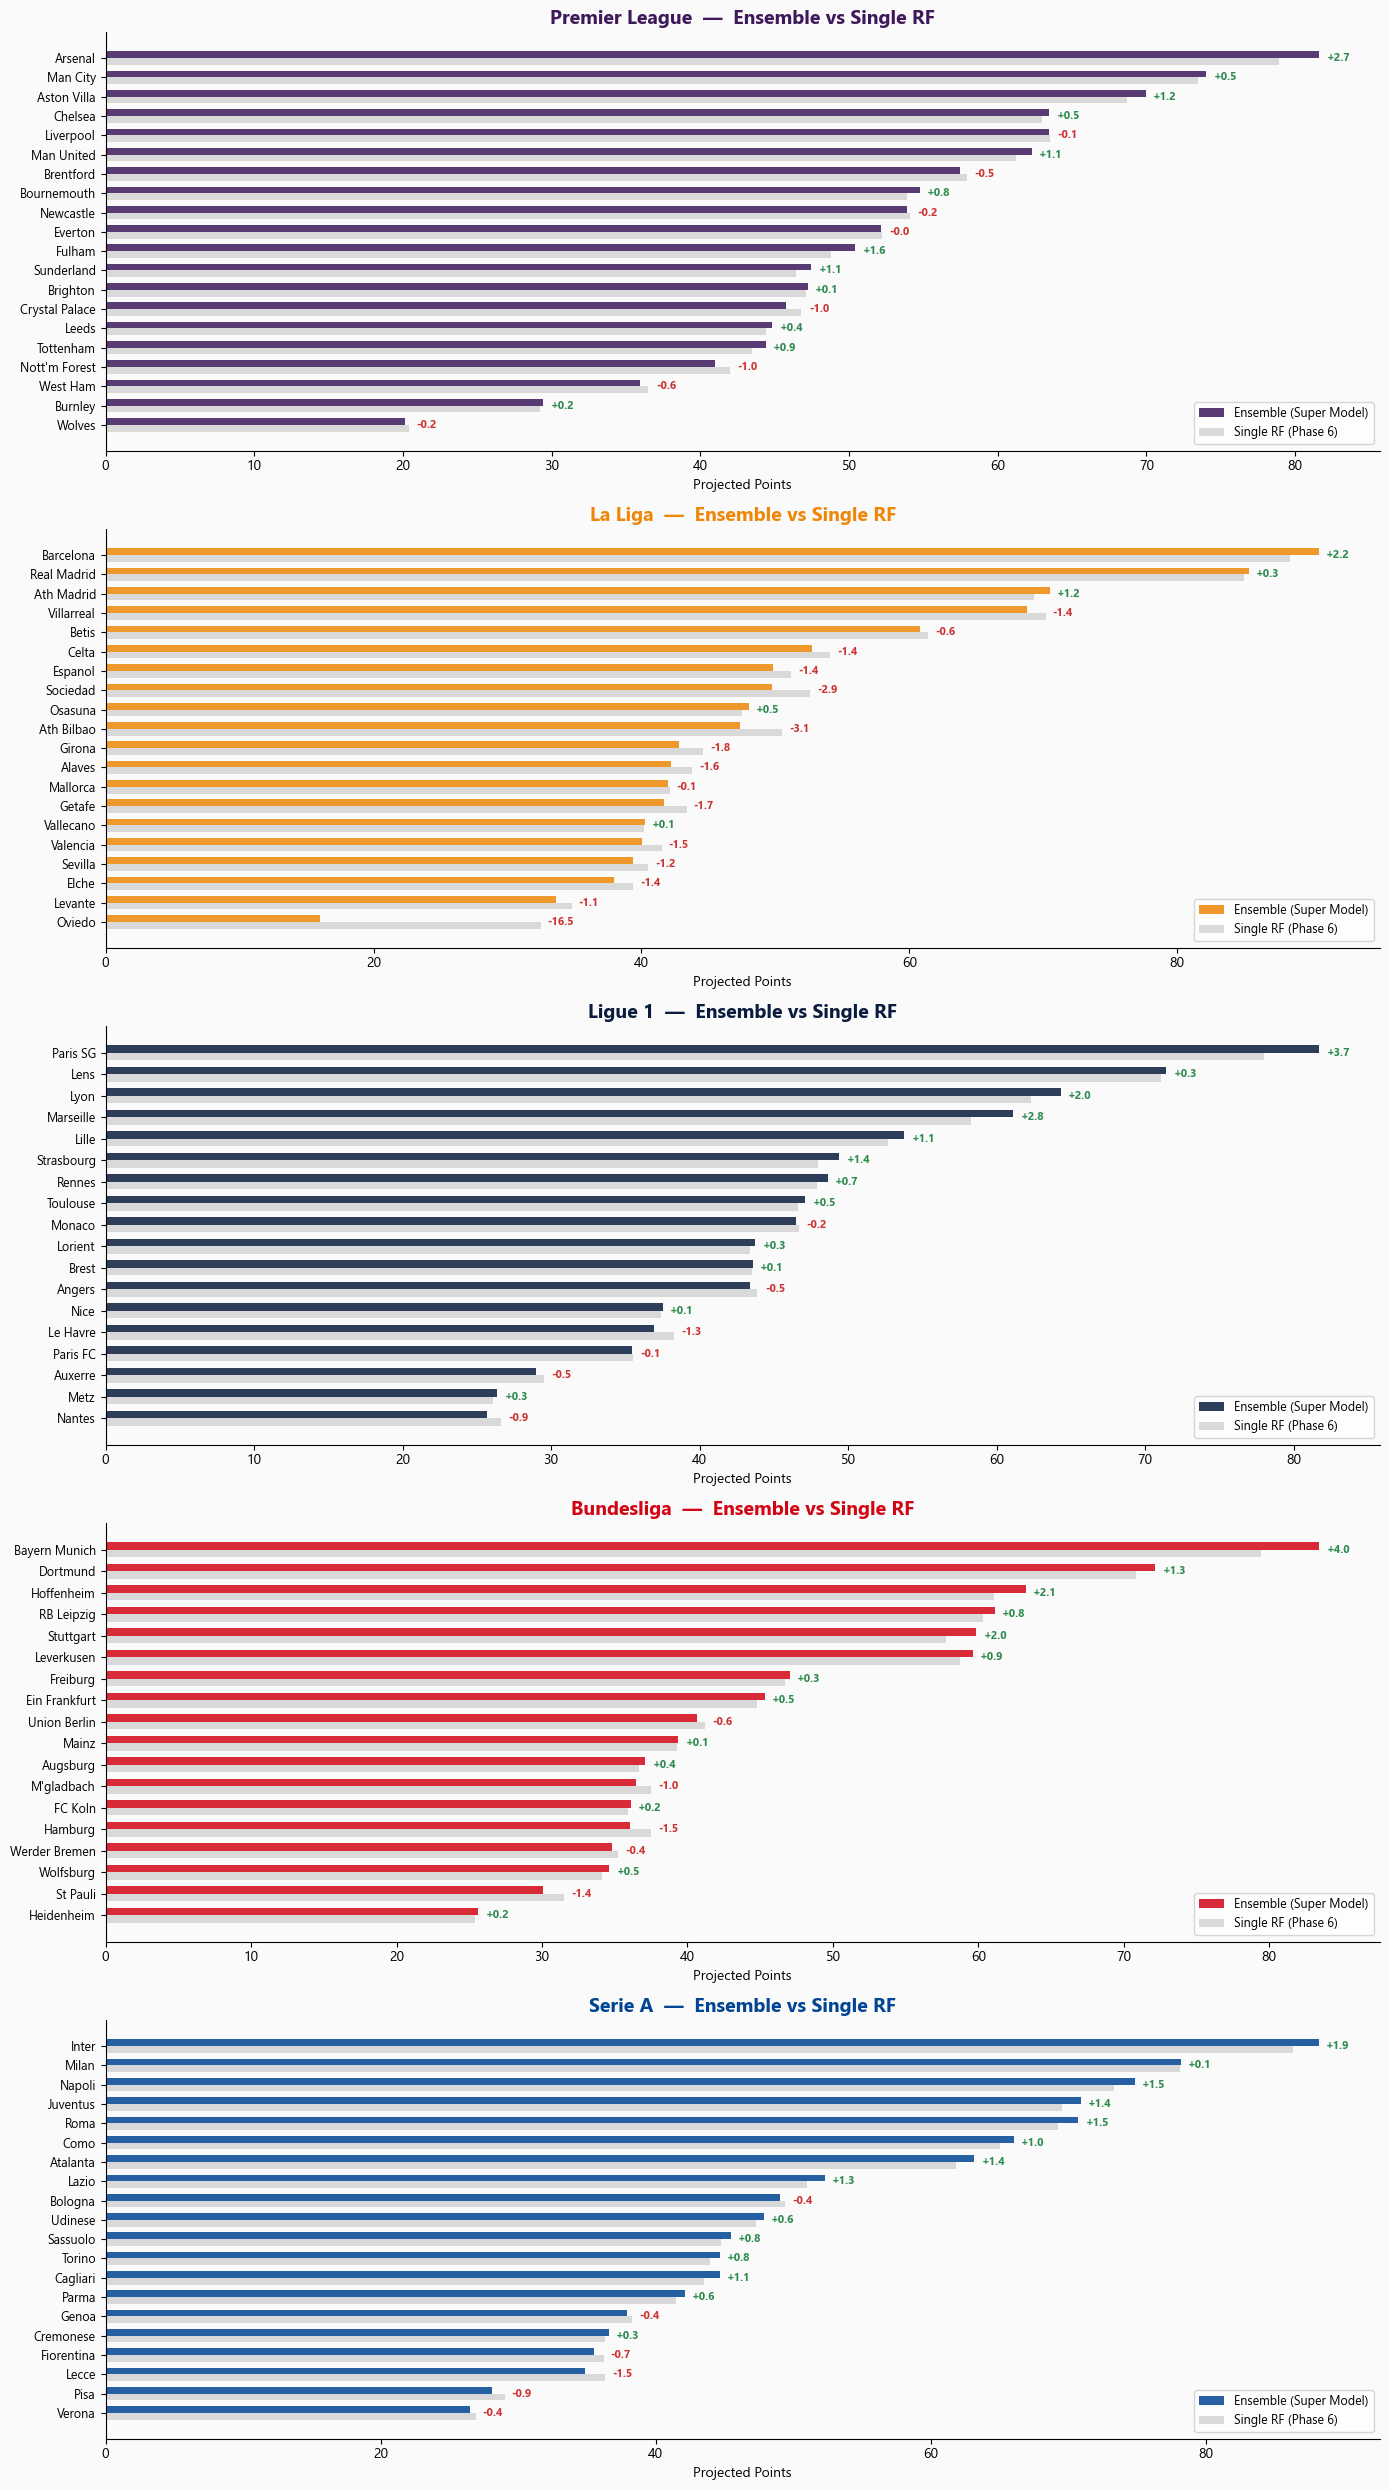

Saved: Report_Assets\Ensemble_vs_RF_Comparison.png


In [6]:
# =============================================================================
# Cell 5: Comparison Visualizations
# =============================================================================

LEAGUE_STYLE = {
    'ENG-Premier League': {'color': '#3d195b', 'name': 'Premier League'},
    'ESP-La Liga':        {'color': '#ee8707', 'name': 'La Liga'},
    'GER-Bundesliga':     {'color': '#d20515', 'name': 'Bundesliga'},
    'ITA-Serie A':        {'color': '#024494', 'name': 'Serie A'},
    'FRA-Ligue 1':        {'color': '#091c3e', 'name': 'Ligue 1'},
}

leagues = sorted(df_compare['league'].unique())
n_leagues = len(leagues)

fig, axes = plt.subplots(n_leagues, 1, figsize=(14, 5 * n_leagues))
fig.patch.set_facecolor('#fafafa')
if n_leagues == 1:
    axes = [axes]

for ax, lg in zip(axes, leagues):
    lg_df = df_compare[df_compare.league == lg].sort_values('ens_projected', ascending=True)
    style = LEAGUE_STYLE.get(lg, {'color': '#333', 'name': lg})
    
    teams = lg_df['team'].values
    y_pos = np.arange(len(teams))
    
    # Bar chart: Ensemble vs RF projected points
    bar_width = 0.35
    bars_ens = ax.barh(y_pos + bar_width/2, lg_df['ens_projected'], bar_width,
                       label='Ensemble (Super Model)', color=style['color'], alpha=0.85)
    bars_rf  = ax.barh(y_pos - bar_width/2, lg_df['ml_projected'], bar_width,
                       label='Single RF (Phase 6)', color='#cccccc', alpha=0.7)
    
    # Add difference annotations
    for i, (_, row) in enumerate(lg_df.iterrows()):
        diff = row['ens_vs_rf']
        color = '#2d8a4e' if diff > 0 else '#cc3333' if diff < 0 else '#888'
        max_pts = max(row['ens_projected'], row['ml_projected'])
        ax.text(max_pts + 0.5, i, f'{diff:+.1f}', va='center', fontsize=8,
                color=color, fontweight='bold')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(teams, fontsize=9)
    ax.set_xlabel('Projected Points', fontsize=10)
    ax.set_title(f'{style["name"]}  —  Ensemble vs Single RF', fontsize=14,
                 fontweight='bold', color=style['color'])
    ax.legend(loc='lower right', fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_facecolor('#fafafa')

plt.tight_layout()
chart_path = os.path.join(ASSETS, 'Ensemble_vs_RF_Comparison.png')
plt.savefig(chart_path, dpi=300, bbox_inches='tight', facecolor='#fafafa')
plt.show()
print(f'Saved: {chart_path}')

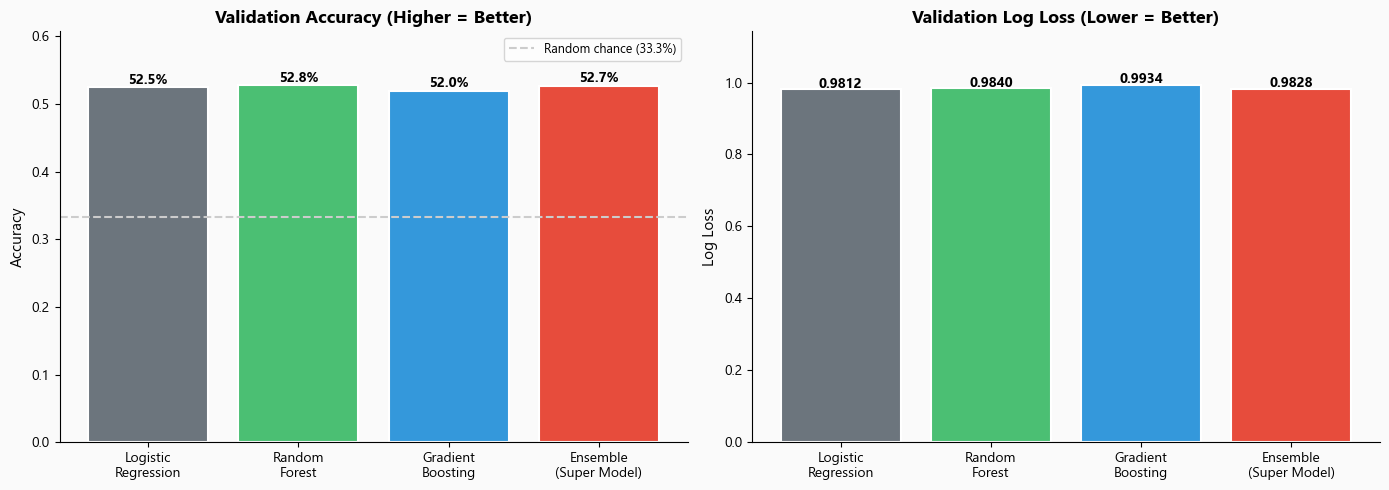

Saved: Report_Assets\Model_Accuracy_Comparison.png

PHASE 9 COMPLETE — ENSEMBLE "SUPER MODEL"
  Models trained:         3 (LR, RF, GB)
  Ensemble method:        Soft Voting (probability average)
  Validation accuracy:    52.69%
  Validation log loss:    0.9828
  Simulations:            10,000
  Future matches scored:  632

  Outputs:
    data\results\Ensemble_Projection.csv
    data\results\Ensemble_vs_RF_Comparison.csv
    Report_Assets\Ensemble_vs_RF_Comparison.png
    Report_Assets\Model_Accuracy_Comparison.png


: 

In [ ]:
# =============================================================================
# Cell 6: Model Accuracy Comparison Chart + Summary
# =============================================================================

models = ['Logistic\nRegression', 'Random\nForest', 'Gradient\nBoosting', 'Ensemble\n(Super Model)']
accuracies = [acc_lr, acc_rf, acc_gb, acc_ens]
log_losses = [ll_lr, ll_rf, ll_gb, ll_ens]
colors = ['#6c757d', '#4bbf73', '#3498db', '#e74c3c']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#fafafa')

# Accuracy bars
bars1 = ax1.bar(models, accuracies, color=colors, edgecolor='white', linewidth=1.5)
ax1.set_ylabel('Accuracy', fontsize=11)
ax1.set_title('Validation Accuracy (Higher = Better)', fontsize=13, fontweight='bold')
ax1.axhline(y=1/3, color='#ccc', linestyle='--', label='Random chance (33.3%)')
ax1.legend(fontsize=9)
for bar, acc in zip(bars1, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{acc:.1%}', ha='center', fontsize=10, fontweight='bold')
ax1.set_ylim(0, max(accuracies) * 1.15)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_facecolor('#fafafa')

# Log Loss bars
bars2 = ax2.bar(models, log_losses, color=colors, edgecolor='white', linewidth=1.5)
ax2.set_ylabel('Log Loss', fontsize=11)
ax2.set_title('Validation Log Loss (Lower = Better)', fontsize=13, fontweight='bold')
for bar, ll in zip(bars2, log_losses):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{ll:.4f}', ha='center', fontsize=10, fontweight='bold')
ax2.set_ylim(0, max(log_losses) * 1.15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_facecolor('#fafafa')

plt.tight_layout()
acc_path = os.path.join(ASSETS, 'Model_Accuracy_Comparison.png')
plt.savefig(acc_path, dpi=300, bbox_inches='tight', facecolor='#fafafa')
plt.show()
print(f'Saved: {acc_path}')

# --- Final summary ---
print(f'\n{"="*60}')
print('PHASE 9 COMPLETE — ENSEMBLE "SUPER MODEL"')
print(f'{"="*60}')
print(f'  Models trained:         3 (LR, RF, GB)')
print(f'  Ensemble method:        Soft Voting (probability average)')
print(f'  Validation accuracy:    {acc_ens:.2%}')
print(f'  Validation log loss:    {ll_ens:.4f}')
print(f'  Simulations:            {SIMULATIONS:,}')
print(f'  Future matches scored:  {len(df_future_clean)}')
print(f'\n  Outputs:')
print(f'    {ens_path}')
print(f'    {comp_path}')
print(f'    {chart_path}')
print(f'    {acc_path}')